# ***Question 01***


---



---
## ***Basic Neural Network- Digit Recognition***


### ***1. Download the MNIST dataset using torch-vision. Split into train, test and validation dataset. Apply Augmentions to images:***
### ***a. Training dataset: RandomRotation(5 degrees), RandomCrop(size=28, padding=2), ToTensor and Normalize.***
### ***b. Testing dataset and validation dataset: ToTensor and Normalize***

In [ ]:
import torch
import torchvision
from torchvision import transforms

# Download MNIST dataset
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=None, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=None, download=True)

print('The size of training data is:', len(train_data))

The size of training data is: 60000


In [ ]:
train_transformations = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_val_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data.transform = train_transformations
test_data.transform = test_val_transformations

In [ ]:
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

### ***2. Plot a few Images from each class. Create a data loader for the training dataset as well as the testing dataset.***

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

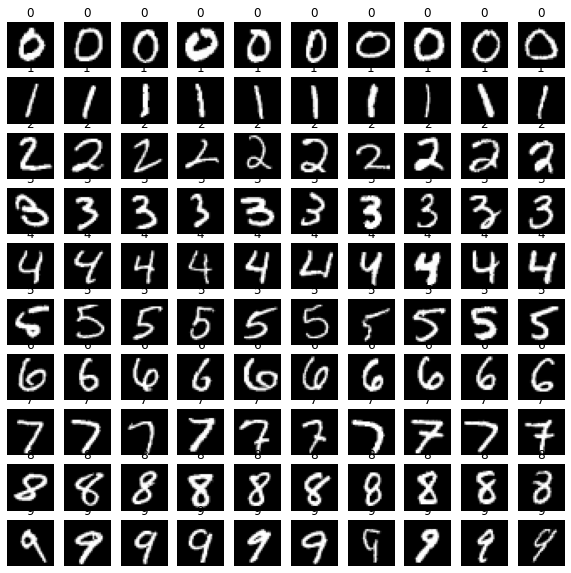

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(data, labels):
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            idx = np.where(labels == (i))[0][j]
            axs[i][j].imshow(data[idx].numpy().squeeze(), cmap='gray')
            axs[i][j].axis('off')
            axs[i][j].set_title(str(i))

plot_images(test_data.data, test_data.targets)

### ***3. Write a 3-Layer MLP using PyTorch all using Linear layers. Print the number of trainable parameters of the model.***

In [ ]:
import torch.nn as nn

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, img):
        ten = img.view(img.size(0), -1) 
        ten = nn.functional.relu(self.fc1(ten))
        ten = nn.functional.relu(self.fc2(ten))
        out = self.fc3(ten)
        return out

model = NN()
print('Number of trainable parameters: ',sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of trainable parameters:  109386


### ***4. Train the model for 5 epochs using Adam as the optimizer and CrossEntropyLoss as the Loss Function. Make sure to evaluate the model on the validation set after each epoch and save the best model as well as log the accuracy and loss of the model on training and validation data at the end of each epoch.***

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
loss_type = nn.CrossEntropyLoss()

best_acc = 0
best_model = None

train_loss, val_loss, train_acc, val_acc = list(), list(), list(), list()

In [ ]:
for epoch in range(5):
    
    model.train()
    loss = 0.0
    correct = 0

    #Training Loop
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_type(outputs, labels)
        loss.backward()

        optimizer.step()

        _, pred = torch.max(outputs, 1)
        loss += loss.item() * inputs.size(0)
        correct += torch.sum(pred == labels.data)

    loss_t = loss / 50000
    acc_t = correct / 50000

    model.eval()

    loss_val = 0.0
    correct_val = 0

    #Validation
    with torch.no_grad():
        for inputs, labels in val_loader:

            outputs = model(inputs)
            loss = loss_type(outputs, labels)

            _, pred = torch.max(outputs, 1)
            loss_val += loss.item() * inputs.size(0)
            correct_val += torch.sum(pred == labels.data)

        loss_val = loss_val / 10000
        acc_val = correct_val / 10000


    train_loss.append(loss_t.item())
    val_loss.append(loss_val)
    train_acc.append(acc_t.item())
    val_acc.append(acc_val.item())
    print('Epoch', epoch+1, 'Training Loss: ', loss_t.item(), 'Validation Loss: ', loss_val, 'Training Accuracy: ', acc_t.item(),  'Validation Accuracy: ', acc_val.item())


    if acc_val > best_acc:
        best_acc = acc_val
        best_model=model

Epoch 1 Training Loss:  1.0368729817855638e-05 Validation Loss:  0.17656426185369492 Training Accuracy:  0.9371200203895569 Validation Accuracy:  0.9473999738693237
Epoch 2 Training Loss:  1.4757048120372929e-05 Validation Loss:  0.16849080516695977 Training Accuracy:  0.9503399729728699 Validation Accuracy:  0.9513999819755554
Epoch 3 Training Loss:  6.53984461678192e-05 Validation Loss:  0.1409285620331764 Training Accuracy:  0.9566799998283386 Validation Accuracy:  0.9591000080108643
Epoch 4 Training Loss:  0.00013889360707253218 Validation Loss:  0.13076180655956268 Training Accuracy:  0.9592000246047974 Validation Accuracy:  0.9593999981880188
Epoch 5 Training Loss:  0.00013571382442023605 Validation Loss:  0.1307902461886406 Training Accuracy:  0.9631800055503845 Validation Accuracy:  0.9588000178337097


### ***5. Visualize correct and Incorrect predictions along with Loss-Epoch and Accuracy-Epoch graphs for both training and validation.***

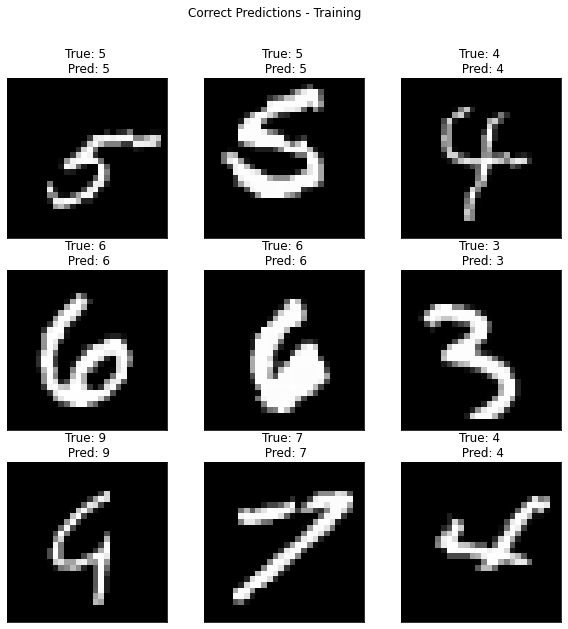

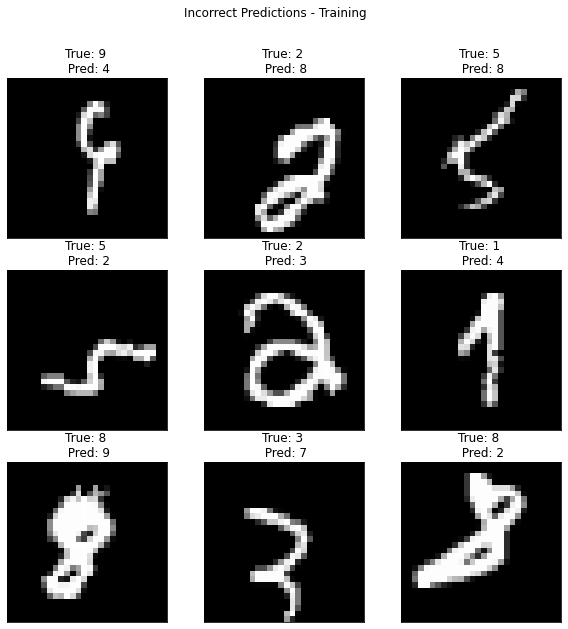

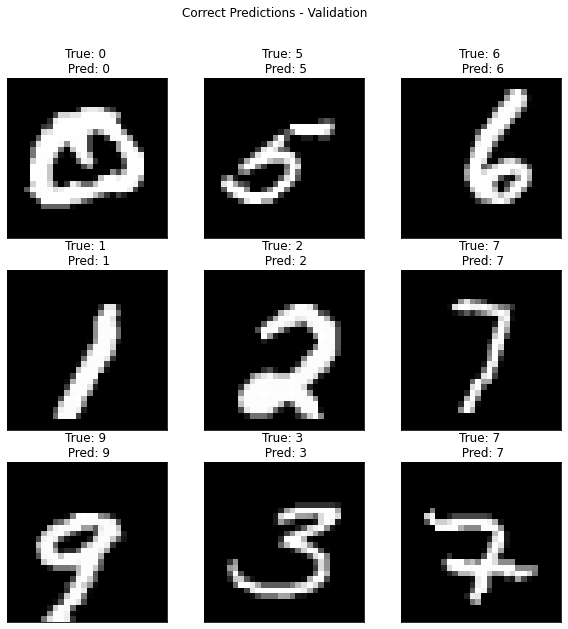

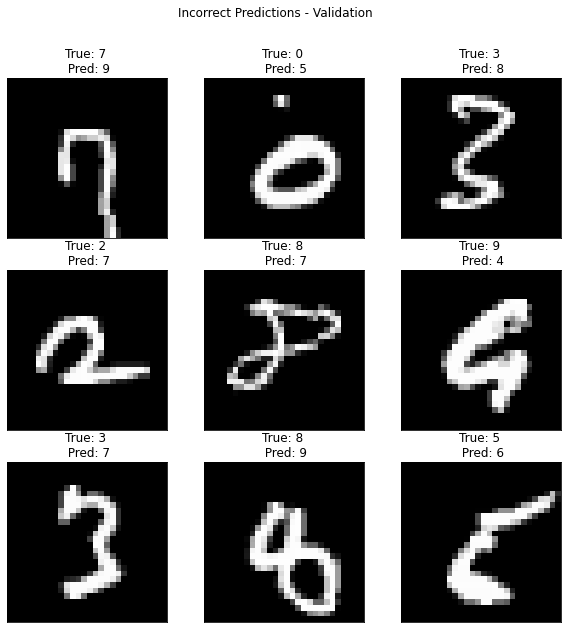

In [ ]:
import matplotlib.pyplot as plt

def get_predictions(model, data_loader):
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            images.append(inputs.cpu())
            labels.append(targets.cpu())
            preds.append(predicted.cpu())
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    preds = torch.cat(preds, dim=0)
    return images, labels, preds

train_images, train_labels, train_preds = get_predictions(model, train_loader)
val_images, val_labels, val_preds = get_predictions(model, val_loader)

def plot_images(images, labels, preds, title):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title)
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'True: {labels[i]} \n Pred: {preds[i]}')
    plt.show()

correct_preds = train_preds.eq(train_labels)
correct_images = train_images[correct_preds]
correct_labels = train_labels[correct_preds]
correct_preds = train_preds[correct_preds]
plot_images(correct_images, correct_labels, correct_preds, 'Correct Predictions - Training')

incorrect_preds = train_preds.ne(train_labels)
incorrect_images = train_images[incorrect_preds]
incorrect_labels = train_labels[incorrect_preds]
incorrect_preds = train_preds[incorrect_preds]
plot_images(incorrect_images, incorrect_labels, incorrect_preds, 'Incorrect Predictions - Training')


correct_preds = val_preds.eq(val_labels)
correct_images = val_images[correct_preds]
correct_labels = val_labels[correct_preds]
correct_preds = val_preds[correct_preds]
plot_images(correct_images, correct_labels, correct_preds, 'Correct Predictions - Validation')

incorrect_preds = val_preds.ne(val_labels)
incorrect_images = val_images[incorrect_preds]
incorrect_labels = val_labels[incorrect_preds]
incorrect_preds = val_preds[incorrect_preds]
plot_images(incorrect_images, incorrect_labels, incorrect_preds, 'Incorrect Predictions - Validation')

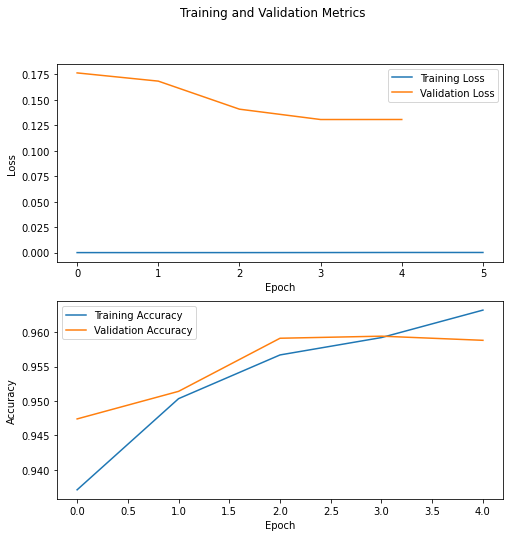

In [ ]:
# Plot the loss-epoch and accuracy-epoch graphs for the training and validation sets
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
fig.suptitle('Training and Validation Metrics')
axs[0].plot(train_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(train_acc, label='Training Accuracy')
axs[1].plot(val_acc, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

# ***QUESTION 2***


---



---

## ***Implement ANN from scratch***

### ***1. Preprocess & visualize the data. Create train, val, and test splits but take into consideration the class distribution (Hint: Look up stratified splits).***

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

abalone_data = pd.read_csv('/content/drive/MyDrive/PRML/Lab 9/abalone.data',
                           names=['Sex', 'Length', 'Diameter', 'Height', 'Whole weigth', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'],
                           header=None)

In [62]:
abalone_data

,Sex,Length,Diameter,Height,Whole weigth,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [63]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weigth    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [64]:
abalone_data.nunique()

Sex                  3
Length             134
Diameter           111
Height              51
Whole weigth      2429
Shucked weight    1515
Viscera weight     880
Shell weight       926
Rings               28
dtype: int64

In [65]:
print(abalone_data['Rings'])

0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: Rings, Length: 4177, dtype: int64


In [66]:
abalone_data = pd.get_dummies(abalone_data, columns = ['Sex'])
print(abalone_data)

      Length  Diameter  Height  Whole weigth  Shucked weight  Viscera weight  \
0      0.455     0.365   0.095        0.5140          0.2245          0.1010   
1      0.350     0.265   0.090        0.2255          0.0995          0.0485   
2      0.530     0.420   0.135        0.6770          0.2565          0.1415   
3      0.440     0.365   0.125        0.5160          0.2155          0.1140   
4      0.330     0.255   0.080        0.2050          0.0895          0.0395   
...      ...       ...     ...           ...             ...             ...   
4172   0.565     0.450   0.165        0.8870          0.3700          0.2390   
4173   0.590     0.440   0.135        0.9660          0.4390          0.2145   
4174   0.600     0.475   0.205        1.1760          0.5255          0.2875   
4175   0.625     0.485   0.150        1.0945          0.5310          0.2610   
4176   0.710     0.555   0.195        1.9485          0.9455          0.3765   

      Shell weight  Rings  Sex_F  Sex_I

In [67]:
abalone_y = abalone_data['Rings']
abalone_x = abalone_data.drop(['Rings'], axis=1)

In [68]:
for i in range(len(abalone_y)):
    if 0<abalone_y[i]<9:
        abalone_y[i] = 1
    elif 8<abalone_y[i]<11:
        abalone_y[i] = 2
    else:
        abalone_y[i] = 3 

<ipython-input-68-d01fb027d0db>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abalone_y[i] = 3
<ipython-input-68-d01fb027d0db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abalone_y[i] = 1
<ipython-input-68-d01fb027d0db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abalone_y[i] = 2


In [69]:
abalonex_np = abalone_x.to_numpy()
abaloney_np = abalone_y.to_numpy()

In [70]:
abaloney_np

array([3, 1, 2, ..., 2, 2, 3])

In [71]:
from sklearn.model_selection import train_test_split as split

train_ax, test_ax, train_ay, test_ay = split(abalonex_np, abaloney_np, train_size=0.8, stratify=abaloney_np)

### ***2. Implement a multi-layer perceptron from scratch. This would include the following***
**a. Write activation functions.**

**b. Forward propagate the input.**

**c. Back propagate the error.**

**d. Train the network using stochastic gradient descent.**

**e. Predict the output for a given test sample and compute the accuracy.**

In [72]:
import numpy as np
from math import exp
import time
import math

In [73]:
class NN():

    def __init__(self, params = 0, learning_rate=1, epochs=5):
        self.epochs = epochs
        self.alpha = learning_rate
        self.params = params

        self.layer_info = {}
        self.layers = {}
        self.num_layers = 1
        self.weights = {}
        self.biases = {}

        self.epoch_loss = []
        self.epoch_acc = []
        # self.activations = {}

        return None

    def __sigmoid(self, z):

        sigmoid = lambda t: 1/(1 + exp(t))
        gz = np.array([sigmoid(zi) for zi in z])

        # gz = gz.reshape((-1, 1))

        return gz

    def __relu(self, z):

        reLu = lambda t: max(0, t)
        gz = np.array([reLu(zi) for zi in z])

        # gz = gz.reshape((-1, 1))

        return gz

    def __tanh(self, z):
        
        tanh = lambda t: (exp(t) - exp(-t))/(exp(t) + exp(-t))
        gz = np.array([tanh(zi) for zi in z])

        # gz = gz.reshape((-1, 1))

        return gz

    def __softmax(self, x):

        e_sum = 0
        prob = []

        for i in x:
            e_sum += exp(i)
        
        for i in x:
            prob.append(exp(i)/e_sum)

        max_prob = 0
        pred = 0
        for i in range(len(prob)):
            if prob[i] > max_prob:
                max_prob = prob[i]
                pred = i+1

        # print(prob)
        prob = np.array(prob)
        return prob, pred

    def InputLayer(self, input_size):

        self.layers['Input_Layer'] = {'size': input_size}

        return f'<Input Layer: input size={input_size}>'

    def Linear(self, n_neurons=1, activation=None):

        self.layers[f'Layer_{self.num_layers}'] = {'size': n_neurons,
                                                   'neurons': np.zeros(n_neurons),
                                                   'activation': activation
                                                   }
        
        self.num_layers += 1
        
        return f'<Linear Layer: size={n_neurons}, activation={activation}>'

    def Softmax(self, num_classes):

        self.num_classes = num_classes

        self.layers['Output_Layer'] = {'size': num_classes,
                                       'activation': 'softmax'
                                       }

        return f'<Softmax Layer: output size={num_classes}>'

    def __initialize_weights(self, in_shape, out_shape):
        
        layer_weights = []

        if self.params == 'random':
            mean = np.zeros(out_shape)
            cov = np.identity(out_shape)

            layer_weights = np.random.multivariate_normal(mean=mean, cov=cov, size=in_shape)

            # self.weights.append(layer_weights)

        else:
            layer_weights = np.full((in_shape, out_shape), self.params)
            # self.weights.append(layer_weights)

        return layer_weights

    def __initialize_bias(self, out_shape):

        # print('1')

        layer_bias = np.zeros(out_shape)
        # self.biases.append(layer_bias)

        return layer_bias

    def Sequential(self, layers):
        self.layer_info = layers

        # print(self.__layer_n_neurons)

        # for i in range(len(self.layers)-2):
        #     in_shape = self.__layer_n_neurons[i]
        #     out_shape = self.__layer_n_neurons[i+1]
        #     self.__initialize_weights(in_shape, out_shape)
        #     self.__initialize_bias(out_shape)


        keys = list(self.layers.keys())
        for i in range (0, len(keys)-1):
            in_shape = self.layers[keys[i]]['size']
            out_shape = self.layers[keys[i+1]]['size']
            self.weights[f'Weight_{i+1}'] = self.__initialize_weights(in_shape, out_shape)
            self.biases[f'Bias_{i+1}'] = self.__initialize_bias(out_shape)

        return self

    def __forward(self, x, layer):

        W = self.weights[f'Weight_{layer}']
        b = self.biases[f'Bias_{layer}']

        x = np.dot(x, W) + b


        if self.layers[f'Layer_{layer}']['activation']:
            if self.layers[f'Layer_{layer}']['activation'] == 'sigmoid':
                x = self.__sigmoid(x)
            elif self.layers[f'Layer_{layer}']['activation'] == 'relu':
                x = self.__relu(x)
            elif self.layers[f'Layer_{layer}']['activation'] == 'tanh':
                x = self.__tanh(x)

        return x

    def __forward_propagate(self, x):
        
        for i in range(1, self.num_layers):
            x = self.__forward(x, i)
            self.layers[f'Layer_{i}']['neurons'] = x

        W = self.weights[f'Weight_{self.num_layers}']
        b = self.biases[f'Bias_{self.num_layers}']

        x = np.dot(x, W) + b
        x, pred = self.__softmax(x)
        self.layers['Output_Layer']['neurons'] = x
        
        return x, pred
   
    def __calc_error(self, x, y):
        #multi class cross entropy
        # self.loss = -np.sum(np.log(self.prob))
        del_arr = np.subtract(x, y)
        # loss = np.sum(del_arr)

        loss=0
        for i in range(x.size):
            if y[i] == 0:
                loss = loss
            else:
                loss -= math.log(x[i], 10)

        # print(self.probs)
        # print(np.log(self.probs))
        return del_arr, loss

    def __accuracy(self, prediction, train_y):

        correct = 0
        for i in range(prediction.size):
            if prediction[i] == train_y[i]:
                correct +=1

        acc = correct/train_y.size

        return acc

    def __anti_activations(self, z, activ):

        antiz = []

        for i in z:
            if activ:
                if activ=='sigmoid':
                    antiz.append(i*(1-i))

                elif activ=='relu':
                    if i>0:
                        antiz.append(1)
                    else:
                        antiz.append(0)

                elif activ=='tanh':
                    antiz.append(1-i**2)
                
            else:
                antiz.append(1)

        return np.array(antiz)

    def __back_propagation(self, del_arr, y):

        delta = del_arr
        count=0
        
        layers = list(self.layers.keys())
        for i in range(self.num_layers, 0, -1):
            # print(delta)
            weights_cache = self.weights[f'Weight_{i}']

            self.weights[f'Weight_{i}'] = self.weights[f'Weight_{i}'] - self.alpha*(np.dot(delta.transpose(), self.layers[layers[i]]['neurons']))
            self.biases[f'Bias_{i}'] = self.biases[f'Bias_{i}'] - self.alpha*(delta)

            if i>1:
                # delta = np.multiply(np.dot(self.weights[f'Weight_{i}'], delta.transpose()), self.__anti_activations(self.layers[layers[i-1]]['neurons'], self.layers[layers[i-1]]['activation']))
                delta = np.multiply(np.dot(weights_cache, delta.transpose()), self.__anti_activations(self.layers[layers[i-1]]['neurons'], self.layers[layers[i-1]]['activation']))

        return None

    def train(self):
        output = []
        loss_arr = []
        
        for i in range(len(self.train_x)):
            x = self.train_x[i]
            y = self.enc_trainy[i]
            # print(self.__forward_propagate(x))
            x, pred = self.__forward_propagate(x)
            output.append(pred)

            # print(x)

            # print(x, y, pred)
            # self.probs.append(prob)
            del_arr, loss = self.__calc_error(x, y)
            loss_arr.append(loss)

            self.__back_propagation(del_arr, y)

        loss = sum(loss_arr)/self.train_y.size
        # self.epoch_loss.append(loss)

        output = np.array(output)
        train_acc = self.__accuracy(output, self.train_y)
        # self.epoch_acc.append(train_acc)

        # # print(self.out)
        #     self.__loss()

        #     # print(self.loss)

        return loss, train_acc

    def __encode_labels(self):
        enc_labels = np.zeros((self.train_y.size, self.num_classes))

        for i in range(self.train_y.size):
            enc_labels[i][self.train_y[i]-1] = 1

        return enc_labels

    def fit(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        self.enc_trainy = self.__encode_labels()

        for i in range(1, self.epochs+1):
            st = time.time()
            print(f'Epoch {i} ====>', end='')
            loss, train_acc = self.train()

            self.epoch_loss.append(loss)
            self.epoch_acc.append(train_acc)

            et = time.time()
            elapsed = et - st

            print(f'Total Loss: {loss}           Train Accuracy: {train_acc*100}%            Time Required: {elapsed}s')

        return self.epoch_loss, self.epoch_acc

    def test(self, test_x, test_y):
        
        pred_labels = []

        for i in test_x:
            x, pred = self.__forward_propagate(i)
            pred_labels.append(pred)

        pred_labels = np.array(pred_labels)

        accuracy = self.__accuracy(pred_labels, test_y)

        return pred_labels.transpose(), accuracy*100
    
    def save(self):
        return (self.weights, self.biases)

    def load(self, model):
        self.weights = model[0]
        self.biases = model[1]

        return self


In [75]:
# print(nn.layer_info)
# print(nn.layers)
# print(nn.weights)
# print(nn.biases)

### ***3. Now experiment with different activation functions (at least 3 & to be written from scratch) and comment (in the report) on how the accuracy varies. Create plots to support your arguments.***

In [76]:
import matplotlib.pyplot as plt

In [77]:
epochs = 100

In [78]:
nn = NN(params='random', learning_rate=0.001, epochs=epochs)
model = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(5, 'relu'),
                       nn.Softmax(3)])

relu_losses, relu_accs = model.fit(train_ax, train_ay)
relu_predictions, relu_test_acc = model.test(test_ax, test_ay)

Epoch 1 ====>Total Loss: 0.5273019447833336           Train Accuracy: 27.955701885662975%            Time Required: 0.20281124114990234s
Epoch 2 ====>Total Loss: 0.4537204610731303           Train Accuracy: 49.206824304100564%            Time Required: 0.2513694763183594s
Epoch 3 ====>Total Loss: 0.4489886016299689           Train Accuracy: 47.14157437892846%            Time Required: 0.20220088958740234s
Epoch 4 ====>Total Loss: 0.4461559259481196           Train Accuracy: 47.35109248727925%            Time Required: 0.20832538604736328s
Epoch 5 ====>Total Loss: 0.44333542869856224           Train Accuracy: 47.440885962286735%            Time Required: 0.26562023162841797s
Epoch 6 ====>Total Loss: 0.4415003043608456           Train Accuracy: 47.6204729123017%            Time Required: 0.1895918846130371s
Epoch 7 ====>Total Loss: 0.44247735432913277           Train Accuracy: 47.53067943729422%            Time Required: 0.19137883186340332s
Epoch 8 ====>Total Loss: 0.4440868142334712   

In [79]:
nn = NN(params='random', learning_rate=0.001, epochs=epochs)
model2 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(5, 'tanh'),
                       nn.Softmax(3)])

tanh_losses, tanh_accs = model2.fit(train_ax, train_ay)
tanh_predictions, tanh_test_acc = model2.test(test_ax, test_ay)

Epoch 1 ====>Total Loss: 0.5251116732329124           Train Accuracy: 34.39090092786591%            Time Required: 0.32877540588378906s
Epoch 2 ====>Total Loss: 0.5847207188705956           Train Accuracy: 33.97186471116432%            Time Required: 0.32532835006713867s
Epoch 3 ====>Total Loss: 0.506772205447577           Train Accuracy: 40.856031128404666%            Time Required: 0.3323047161102295s
Epoch 4 ====>Total Loss: 0.47432385376993796           Train Accuracy: 44.717150553726434%            Time Required: 0.32502293586730957s
Epoch 5 ====>Total Loss: 0.46481005682013077           Train Accuracy: 46.33343310386112%            Time Required: 0.3345315456390381s
Epoch 6 ====>Total Loss: 0.45939008607975396           Train Accuracy: 48.009577970667465%            Time Required: 0.3532445430755615s
Epoch 7 ====>Total Loss: 0.45504588172198474           Train Accuracy: 50.07482789583957%            Time Required: 0.5031821727752686s
Epoch 8 ====>Total Loss: 0.4535214289479635   

In [80]:
nn = NN(params='random', learning_rate=0.001, epochs=epochs)
model3 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(5, 'sigmoid'),
                       nn.Softmax(3)])

sigm_losses, sigm_accs = model3.fit(train_ax, train_ay)
sigm_predictions, sigm_test_acc = model3.test(test_ax, test_ay)

Epoch 1 ====>Total Loss: 0.8294688101920354           Train Accuracy: 31.697096677641422%            Time Required: 0.19143152236938477s
Epoch 2 ====>Total Loss: 0.5870877967261446           Train Accuracy: 31.816821310984732%            Time Required: 0.1775803565979004s
Epoch 3 ====>Total Loss: 0.5220272871109265           Train Accuracy: 27.716252618976355%            Time Required: 0.22759246826171875s
Epoch 4 ====>Total Loss: 0.5198191613199267           Train Accuracy: 23.196647710266387%            Time Required: 0.24520540237426758s
Epoch 5 ====>Total Loss: 0.5308312684436738           Train Accuracy: 21.071535468422628%            Time Required: 0.20347857475280762s
Epoch 6 ====>Total Loss: 0.5451641492205582           Train Accuracy: 20.323256510026937%            Time Required: 0.17683982849121094s
Epoch 7 ====>Total Loss: 0.5586848533413289           Train Accuracy: 20.143669560011972%            Time Required: 0.33139801025390625s
Epoch 8 ====>Total Loss: 0.568576240781497

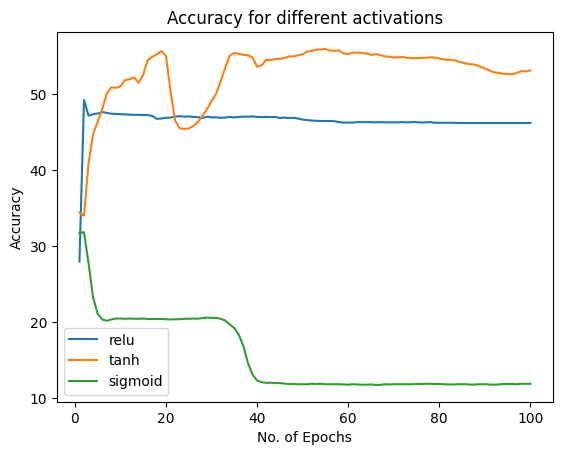

In [81]:
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in relu_accs])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in tanh_accs])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in sigm_accs])
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for different activations")
plt.legend(['relu', 'tanh', 'sigmoid'])
plt.show()

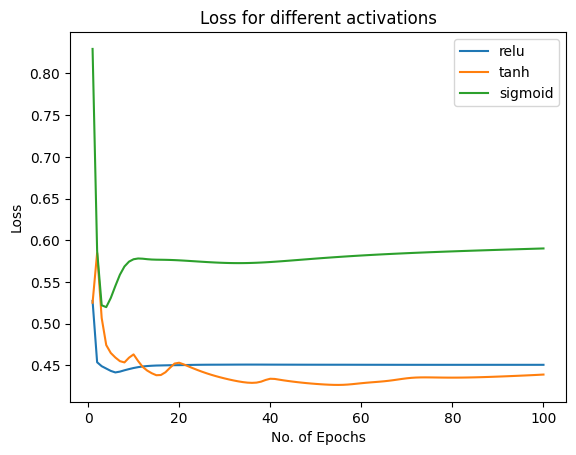

In [82]:
plt.plot([i for i in range(1, epochs+1)], [i for i in relu_losses])
plt.plot([i for i in range(1, epochs+1)], [i for i in tanh_losses])
plt.plot([i for i in range(1, epochs+1)], [i for i in sigm_losses])
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Loss for different activations")
plt.legend(['relu', 'tanh', 'sigmoid'])
plt.show()

### ***4. Experiment with different weight initialization: Random, Zero & Constant. Create plots to support your arguments.***

In [83]:
nn = NN(params='random', learning_rate=0.001, epochs=epochs)
model4 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(5, 'tanh'),
                       nn.Softmax(3)])

ran_losses, ran_accs = model4.fit(train_ax, train_ay)
ran_predictions, ran_test_acc = model4.test(test_ax, test_ay)
print(f'Test Accuracy: {ran_test_acc}')

Epoch 1 ====>Total Loss: 0.8127439833699814           Train Accuracy: 18.82669859323556%            Time Required: 0.1867384910583496s
Epoch 2 ====>Total Loss: 0.6838636987286694           Train Accuracy: 19.81442681831787%            Time Required: 0.22712182998657227s
Epoch 3 ====>Total Loss: 0.6299403132426268           Train Accuracy: 21.55043400179587%            Time Required: 0.19887518882751465s
Epoch 4 ====>Total Loss: 0.6011684947734384           Train Accuracy: 23.466028135288834%            Time Required: 0.18884491920471191s
Epoch 5 ====>Total Loss: 0.5718297253091899           Train Accuracy: 24.78299910206525%            Time Required: 0.17820405960083008s
Epoch 6 ====>Total Loss: 0.5504911862939442           Train Accuracy: 25.082310685423526%            Time Required: 0.2778809070587158s
Epoch 7 ====>Total Loss: 0.5360423331607014           Train Accuracy: 25.860520802155047%            Time Required: 0.20315861701965332s
Epoch 8 ====>Total Loss: 0.527034314819947     

In [84]:
nn = NN(params=0, learning_rate=0.001, epochs=epochs)
model5 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(5, 'tanh'),
                       nn.Softmax(3)])

zero_losses, zero_accs = model5.fit(train_ax, train_ay)
zero_predictions, zero_test_acc = model5.test(test_ax, test_ay)
print(f'Test Accuracy: {zero_test_acc}')

Epoch 1 ====>Total Loss: 0.47707628327471563           Train Accuracy: 33.97186471116432%            Time Required: 0.3221607208251953s
Epoch 2 ====>Total Loss: 0.47696416529885094           Train Accuracy: 34.15145166117929%            Time Required: 0.19257354736328125s
Epoch 3 ====>Total Loss: 0.47694597235725106           Train Accuracy: 34.12152050284346%            Time Required: 0.21294260025024414s
Epoch 4 ====>Total Loss: 0.47694206881311485           Train Accuracy: 34.15145166117929%            Time Required: 0.19078946113586426s
Epoch 5 ====>Total Loss: 0.47694101993249716           Train Accuracy: 34.181382819515115%            Time Required: 0.21509075164794922s
Epoch 6 ====>Total Loss: 0.4769407014487781           Train Accuracy: 34.181382819515115%            Time Required: 0.18050718307495117s
Epoch 7 ====>Total Loss: 0.4769405995868427           Train Accuracy: 34.181382819515115%            Time Required: 0.18113231658935547s
Epoch 8 ====>Total Loss: 0.47694056635161

In [85]:
nn = NN(params=2, learning_rate=0.001, epochs=epochs)
model6 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(5, 'tanh'),
                       nn.Softmax(3)])

const_losses, const_accs = model6.fit(train_ax, train_ay)
const_predictions, const_test_acc = model6.test(test_ax, test_ay)
print(f'Test Accuracy: {const_test_acc}')

Epoch 1 ====>Total Loss: 0.4770762832747156           Train Accuracy: 33.97186471116432%            Time Required: 0.22223377227783203s
Epoch 2 ====>Total Loss: 0.47696416529885105           Train Accuracy: 34.15145166117929%            Time Required: 0.24360013008117676s
Epoch 3 ====>Total Loss: 0.4769459723572511           Train Accuracy: 34.12152050284346%            Time Required: 0.2186260223388672s
Epoch 4 ====>Total Loss: 0.47694206881311485           Train Accuracy: 34.15145166117929%            Time Required: 0.2715723514556885s
Epoch 5 ====>Total Loss: 0.47694101993249705           Train Accuracy: 34.181382819515115%            Time Required: 0.18173480033874512s
Epoch 6 ====>Total Loss: 0.47694070144877815           Train Accuracy: 34.181382819515115%            Time Required: 0.23856091499328613s
Epoch 7 ====>Total Loss: 0.47694059958684254           Train Accuracy: 34.181382819515115%            Time Required: 0.20602774620056152s
Epoch 8 ====>Total Loss: 0.476940566351611

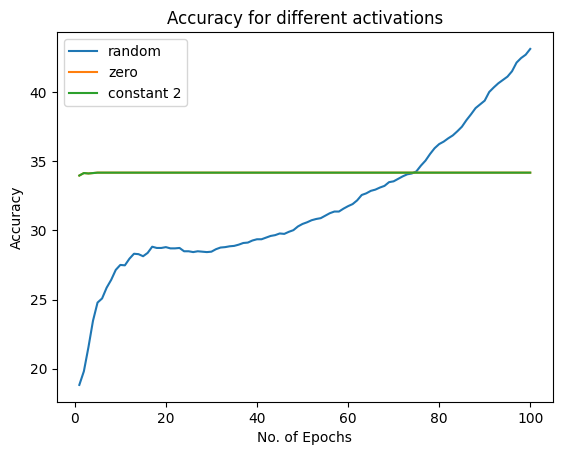

In [86]:
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in ran_accs])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in zero_accs])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in const_accs])
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for different activations")
plt.legend(['random', 'zero', 'constant 2'])
plt.show()

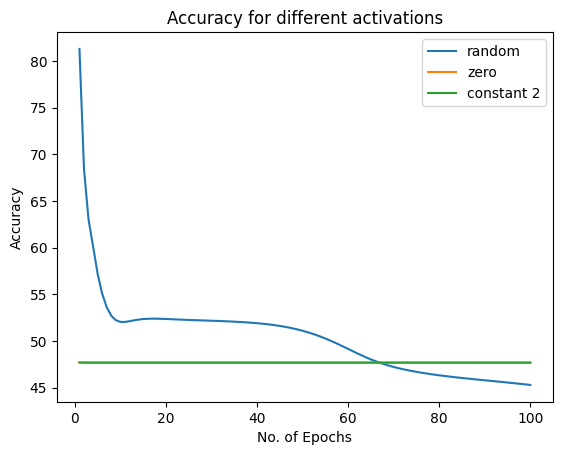

In [87]:
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in ran_losses])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in zero_losses])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in const_losses])
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for different activations")
plt.legend(['random', 'zero', 'constant 2'])
plt.show()

### ***5. Change the number of hidden nodes and comment upon the training and accuracy. Create plots to support your arguments.Add a provision to save and load weights in the MLP.***

In [88]:
nn = NN(params='random', learning_rate=0.001, epochs=epochs)
model7 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(8, 'relu'),
                       nn.Linear(5, 'relu'),
                       nn.Softmax(3)])

h1_losses, h1_accs = model7.fit(train_ax, train_ay)
h1_predictions, h1_test_acc = model7.test(test_ax, test_ay)
print(f'Test Accuracy: {h1_test_acc}')

Epoch 1 ====>Total Loss: 0.4770498923438786           Train Accuracy: 47.41095480395091%            Time Required: 0.36339426040649414s
Epoch 2 ====>Total Loss: 0.4235277788759086           Train Accuracy: 53.81622268781802%            Time Required: 0.33226442337036133s
Epoch 3 ====>Total Loss: 0.4158378006653041           Train Accuracy: 53.06794372942233%            Time Required: 0.33595705032348633s
Epoch 4 ====>Total Loss: 0.41048644291149516           Train Accuracy: 53.45704878778809%            Time Required: 0.3807218074798584s
Epoch 5 ====>Total Loss: 0.4074990976377572           Train Accuracy: 53.756360371146364%            Time Required: 0.31340742111206055s
Epoch 6 ====>Total Loss: 0.40538727090065374           Train Accuracy: 53.96587847949716%            Time Required: 0.3111608028411865s
Epoch 7 ====>Total Loss: 0.40383364984339254           Train Accuracy: 54.29512122119126%            Time Required: 0.3381824493408203s
Epoch 8 ====>Total Loss: 0.4024602085964781    

In [89]:
nn = NN(params='random', learning_rate=0.001, epochs=epochs)
model8 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(8, 'relu'),
                    #    nn.Linear(5, 'relu'),
                       nn.Softmax(3)])

h2_losses, h2_accs = model8.fit(train_ax, train_ay)
h2_predictions, h2_test_acc = model8.test(test_ax, test_ay)
print(f'Test Accuracy: {h2_test_acc}')

Epoch 1 ====>Total Loss: 0.45328779882419384           Train Accuracy: 52.319664771026645%            Time Required: 0.26340436935424805s
Epoch 2 ====>Total Loss: 0.43553344734368           Train Accuracy: 51.75097276264592%            Time Required: 0.25011324882507324s
Epoch 3 ====>Total Loss: 0.434703189852292           Train Accuracy: 52.17000897934751%            Time Required: 0.22112607955932617s
Epoch 4 ====>Total Loss: 0.43571598591253846           Train Accuracy: 51.99042202933254%            Time Required: 0.22610187530517578s
Epoch 5 ====>Total Loss: 0.4367475141291898           Train Accuracy: 52.319664771026645%            Time Required: 0.2757599353790283s
Epoch 6 ====>Total Loss: 0.4375715603874847           Train Accuracy: 52.439389404369955%            Time Required: 0.24706602096557617s
Epoch 7 ====>Total Loss: 0.4381461563932078           Train Accuracy: 52.559114037713265%            Time Required: 0.2179429531097412s
Epoch 8 ====>Total Loss: 0.43861399116782634   

In [90]:
nn = NN(params='random', learning_rate=0.001, epochs=epochs)
model9 = nn.Sequential([nn.InputLayer(10),
                       nn.Linear(8, 'relu'),
                       nn.Linear(4, 'relu'),
                       nn.Softmax(3)])

h3_losses, h3_accs = model9.fit(train_ax, train_ay)
h3_predictions, h3_test_acc = model9.test(test_ax, test_ay)
print(f'Test Accuracy: {h3_test_acc}')

Epoch 1 ====>Total Loss: 0.46210123740156883           Train Accuracy: 41.544447770128706%            Time Required: 0.5474793910980225s
Epoch 2 ====>Total Loss: 0.43897432846186           Train Accuracy: 47.17150553726429%            Time Required: 0.5449907779693604s
Epoch 3 ====>Total Loss: 0.43010801850038377           Train Accuracy: 47.50074827895839%            Time Required: 0.5199887752532959s
Epoch 4 ====>Total Loss: 0.42298002059808176           Train Accuracy: 49.14696198742891%            Time Required: 0.5072405338287354s
Epoch 5 ====>Total Loss: 0.417092756919595           Train Accuracy: 50.224483687518706%            Time Required: 0.5330009460449219s
Epoch 6 ====>Total Loss: 0.4113012857241718           Train Accuracy: 51.062556120921876%            Time Required: 0.45960307121276855s
Epoch 7 ====>Total Loss: 0.4064165165722485           Train Accuracy: 51.541454654295116%            Time Required: 0.4038572311401367s
Epoch 8 ====>Total Loss: 0.404016240188878        

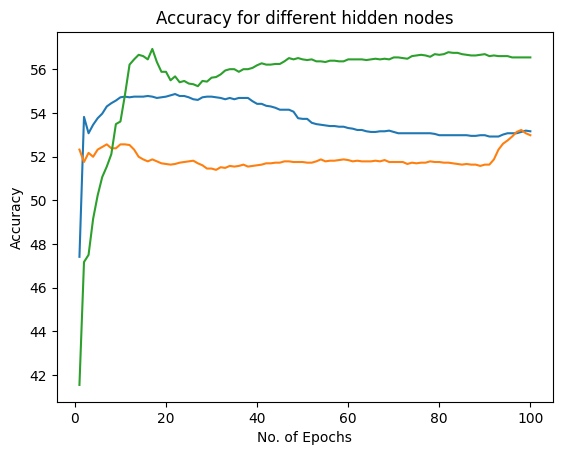

In [91]:
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in h1_accs])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in h2_accs])
plt.plot([i for i in range(1, epochs+1)], [i*100 for i in h3_accs])
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for different hidden nodes")
# plt.legend(['random', 'zero', 'constant 2'])
plt.show()

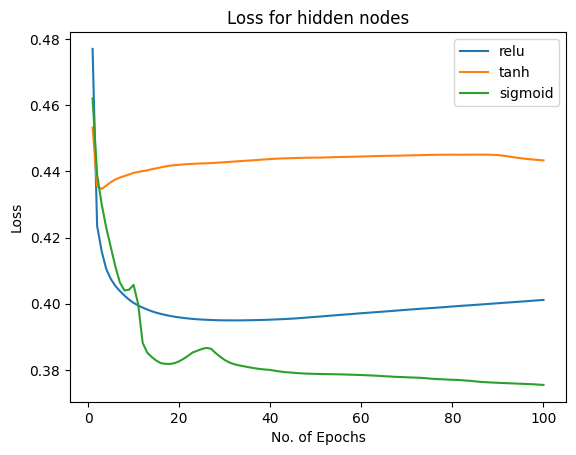

In [92]:
plt.plot([i for i in range(1, epochs+1)], [i for i in h1_losses])
plt.plot([i for i in range(1, epochs+1)], [i for i in h2_losses])
plt.plot([i for i in range(1, epochs+1)], [i for i in h3_losses])
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Loss for hidden nodes")
plt.legend(['relu', 'tanh', 'sigmoid'])
plt.show()

# ***Question 03***


---



---
## ***Experiment with Architecture***


## ***A. Google PlayGround***

---



a. If the model is underfitting then increasing the size of the network will help but if the model is working fine then it may start overfitting on increase in size and will lead to a bad model.
Change in convergence on increasing size depends on factors such as the type of dataset being used and also the number of training examples. Therefore, it is variable and cannot be said to only fasten or slow down the convergence in all cases.

c. The best model was obtained with two hidden layers (3 neurons in first layer and 2 neurons in second layer). Activation was kept ReLU, the model was working well with tanh too but minmum loss was obtained with ReLU. Also regularization was kept to be L1. The minimum loss obtained was 0.119 for train and 0.162 for test. The test loss was around 0.01 higher along with the difference in loss in train and test being higher in case of L2 regularization and so L1 was chosen. The training surface had blunt edges.

## ***B. Neural Nets V2 Desmos Visualized***

---



The model was more prone to changes at higher learning rates and the decision boundary changed very quickly with number of iterations. But in case of smaller learning rate the decision boundary changed very slowly and with learning rate less than 0.1 it seemed to be almost constant initially. Thus the training stability decreased with increase in learning rate as the model became more prone to changes with given inputs.

b. Each model converged in around 80-120 steps. The shape of convergence was similar in all the trials but in some trials the error vale increased slightly after achieving minimum while in some it remained on an almost constant trend.
Added one more layer with a single node and also added an extra node to pre-existing hidden layer. In this case, the train loss decreased quickly at first and then remained constant while the test loss decreased a little bit and after hitting a minimum (which was still significantly more than the train loss at that epoch), increased significantly.